# Analysis of hazardous asteroids' orbital parameters

Using data on already discovered asteroid's we'll try to analyse orbital parameters of near-Earth asteroids and  find out familes of orbits with high probability of yet undiscovered potentially hazardous asteroids existance.

In [1]:
%matplotlib inline
import itertools
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import pickle, sys, os, time
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm
from sklearn.neighbors.kde import KernelDensity

import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al
from copy import deepcopy

font = {'size': 14}
matplotlib.rc('font', **font)

### ASTEROID DATABASE

**Load asteroid database:**

In [2]:
columns = ['a', 'e', 'i', 'w', 'om', 'q', 'H', 'neo', 
               'pha', 'moid', 'per', 'n', 'ma', 'epoch']

database = rdb.load_database(columns, jobtime=True)
database.head(n=5)

Loading asteroid database...
Asteroid database loaded in 5.896000 seconds.


,neo,pha,H,epoch,e,a,q,i,om,w,ma,n,per,moid
0,N,N,3.34,2457600.5,0.075705,2.768134,2.558572,10.591705,80.314273,72.814757,224.095256,0.214005,1682.205859,1.59307
1,N,N,4.13,2457600.5,0.230835,2.772779,2.132725,34.841162,173.087844,309.999215,206.286381,0.213467,1686.441928,1.23093
2,N,N,5.33,2457600.5,0.256601,2.668831,1.984005,12.990102,169.862997,248.236797,168.734429,0.226059,1592.501978,1.03424
3,N,N,3.20,2457600.5,0.089067,2.361348,2.151031,7.140406,103.842512,151.111635,183.876822,0.271621,1325.374085,1.13866
4,N,N,6.85,2457600.5,0.191552,2.574343,2.081222,5.367954,141.591962,358.878896,43.434790,0.238619,1508.682820,1.09307


In [3]:
# TODO: exclude commets

**Extract NEOs:**

In [4]:
neo, num_neo = rdb.get_neo(database, columns)

** Exclude NEOs with large semi-major axis **

In [5]:
print len(neo[neo.a > 4])

12


In [ ]:
neo = neo[neo.a < 4]

** Exclude NEOs with high inclination **

In [6]:
print len(neo[neo.i > 90])

2


In [7]:
neo = neo[neo.i < 90]

14845


**Split NEOs by groups:**

In [8]:
apollos, num_apollos = rdb.get_apollos(neo)
atens, num_atens = rdb.get_atens(neo)
amors, num_amors = rdb.get_amors(neo)
neo_close = neo[neo.q <= 1.08]

print "apollos:", num_apollos, "neo:", num_neo, "ratio:", num_apollos/float(num_neo)
print "atens:", num_atens, "neo:", num_neo, "ratio:", num_atens/float(num_neo)
print "amors:", num_amors, "neo:", num_neo, "ratio:", num_amors/float(num_neo)

apollos: 7968 neo: 14845 ratio: 0.536746379252
atens: 1 neo: 14845 ratio: 6.73627484001e-05
amors: 5774 neo: 14845 ratio: 0.388952509262


**Cut off apollo asteroids with extreme orbital parameters:**

In [9]:
# apollos, num_apollos = rdb.cutoff_outliers(apollos)

**Extract hazardous and nonhazardous orbits from apollo group**

In [10]:
# haz_real, nohaz_real = rdb.get_hazMOID(apollos)

**Extract hazardous and nonhazardous orbits from NEOs**

In [11]:
# haz_real, nohaz_real = rdb.get_hazMOID(neo)
haz_real, nohaz_real = rdb.get_hazMOID(neo_close)

** Visualise distributions of orbital parameters combinations **

In [14]:
# haz_real, nohaz_real = rdb.get_hazMOID(apollos)
# vd.display_allparams([haz_real, nohaz_real], vd.combs, vd.colnames)
# vd.display_allparams([neo_close, neo_close], vd.combs, vd.colnames)
# vd.display_allparams([neo_small, neo_small], vd.combs, vd.colnames)

## GENERATE RANDOM ASTEROIDS

**Specify a subset of asteroid parameters:**

In [15]:
names = ['a', 'i', 'w', 'om', 'q']
full_names = [vd.colnames[nm] for nm in names]
data_subset = neo_close[names]

### Pick an appropriate range of fitting continuous distributions for the orbital parameters of asteroid subsets

Data cdf(xmax): 1.000000 	rayleigh_cdf(xmax): 0.999225
Data cdf(xmax): 1.000000 	lognorm_cdf(xmax): 0.982480
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	harmonic_cdf(xmax): 0.999970
Data cdf(xmax): 1.000000 	johnsonsu_cdf(xmax): 0.923352


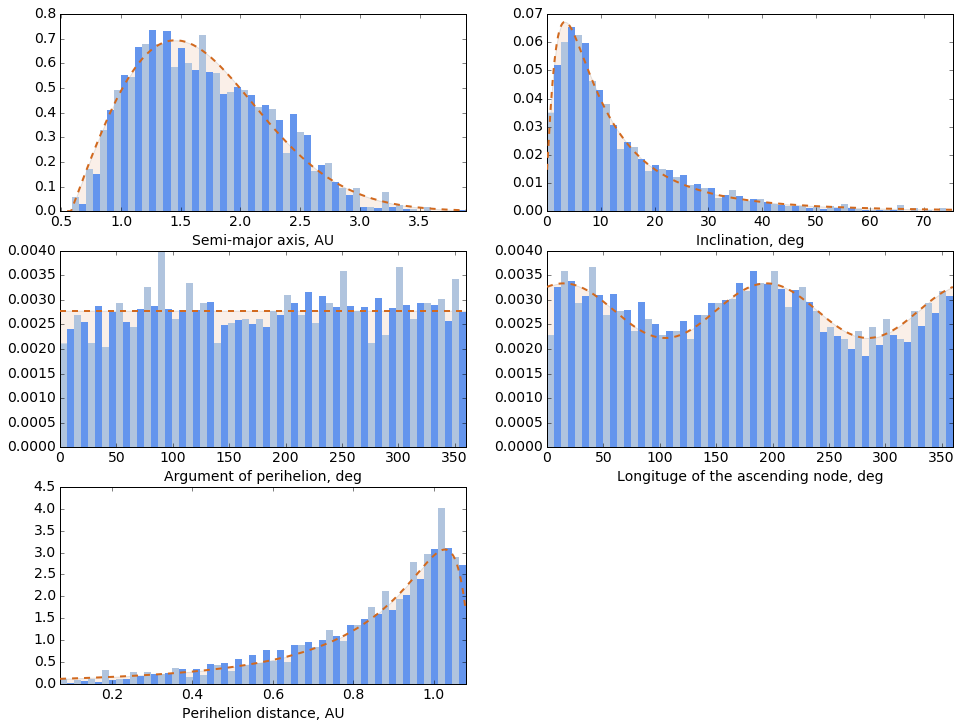

In [17]:
# dname = go.dist_names[44] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "qmod = ss.%s" % dname
# amod = alpha, betaprime, f!, fatiguelife, genextreme, gausshyper, gamma, gumbel_r, invgamma, pearson3!, rayleigh!!!
# amod = go.GaussianKDE(data_subset['a'])
# qmod = gumbel_l, johnsonsb!!!

statdists = [ss.rayleigh, ss.lognorm, ss.uniform, go.HarmonicDistribution(), ss.johnsonsu]
distlist = go.get_param_distributions(data_subset, names, statdists, n=30, verbose=True)
go.plot_param_distributions(distlist, full_names, figsize=(16, 12))

### Generate random asteroids for the range of orbital parameters represented by the subsets of asteroids

** Subset of close NEAs with small values of semimajor axis **

In [18]:
# dname = go.dist_names[80] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "amod = ss.%s" % dname
# # amod = cosine, f, frechet_r, frechet_l!!!, johnsonsb!!!, loggamma, pearson3, rice, weibull_min!!!

# statdists = [ss.frechet_l, ss.lognorm, go.HarmonicDistribution(), go.HarmonicDistribution(), ss.genextreme]
# distlist_small = go.get_param_distributions(data_subset_small, names, statdists, n=30, verbose=True)
# go.plot_param_distributions(distlist_small, full_names, figsize=(16, 12))

** Subset of close NEAs with big values of semimajor axis **

In [19]:
# dname = go.dist_names[15] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "amod = ss.%s" % dname
# amod = alpha, burr!!, chi!!!, chi2, exponweib!!!!!!

# statdists = [ss.exponweib, ss.lognorm, ss.uniform, go.HarmonicDistribution(), ss.genextreme]
# distlist_big = go.get_param_distributions(data_subset_big, names, statdists, n=30, verbose=True)
# go.plot_param_distributions(distlist_big, full_names, figsize=(16, 12))

** Subset of asteroids with small values of semimajor axis **

In [74]:
# dname = go.dist_names[81] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "qmod = ss.%s" % dname
# qmod = ss.rayleigh
# qmod = go.GaussianKDE(data_subset['q'])
# qmod = ss.dgamma, frechet_r, frechet_r, genlogistic, genextreme, gamma, gumbel_r, hypsecant, invgamma, 
# invgauss, johnsonsu, laplace!, maxwell, nct, rayleigh!, recipinvgauss, weibull_min, weibull_max

In [76]:
# emod = go.GaussianKDE(data_subset['e'])
# statdists = [ss.johnsonsb, ss.lognorm, go.HarmonicDistribution(), go.HarmonicDistribution(), ss.genlogistic]
# distlist_common = go.get_param_distributions(data_subset, names, statdists, n=30, verbose=True)
# go.plot_param_distributions(distlist_common, full_names, figsize=(16, 12))

In [36]:
# names = ['e', 'i', 'om', 'w']
# full_names = [vd.colnames[nm] for nm in names]
# data_subset_inner = neo_inner[names]
# data_subset_outer = neo_outer[names]

In [18]:
# dname = go.dist_names[15] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "imod = ss.%s" % dname
# print dname
# statdists = [ss.johnsonsb, ss.exponweib, go.HarmonicDistribution(), 
#              go.HarmonicDistribution(), ss.genlogistic]
# ss.exponweib
# statdists = [ss.uniform, ss.uniform, ss.uniform, ss.uniform, ss.uniform]

# emod = go.BimodalDistribution(magnitude=0.32)
# qmod = ss.johnsonsb
# imod = betaprime, chi2, exponweib!!!
# imod = ss.exponweib
# qmod = ss.johnsonsb
# qmod = go.HarmonicDistribution(dmin=0.0, dmax=300.0)
# qmod = go.BimodalDistribution(dist1=ss.expon, dist2=ss.uniform, magnitude=0.5)

# statdists = [emod, ss.gilbrat, ss.uniform, go.HarmonicDistribution(), ss.uniform] 
# laplace dweibull genlogistic ss.gilbrat

In [37]:
# emod = go.GaussianKDE(data_subset_inner['e'])
# statdists = [emod, ss.lognorm, go.HarmonicDistribution(), go.HarmonicDistribution()] 
# distlist_inner = go.get_param_distributions(data_subset_inner, names, statdists, n=30, verbose=True)
# go.plot_param_distributions(distlist_inner, full_names, figsize=(16, 9))

In [20]:
# dname = go.dist_names[7] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "qmod = ss.%s" % dname

In [38]:
# emod = go.GaussianKDE(data_subset_outer['e'])
# statdists = [emod, ss.lognorm, go.HarmonicDistribution(), go.HarmonicDistribution()]
# distlist_outer = go.get_param_distributions(data_subset_outer, names, statdists, n=32, verbose=True)
# go.plot_param_distributions(distlist_outer, full_names, figsize=(16, 9))

In [422]:
# names = ['e', 'i', 'w', 'om', 'q']
# data_subset = neo[names]
# data_subset_ = deepcopy(data_subset)
# qmax = max(data_subset.q)
# data_subset_.q = qmax - data_subset.q

In [14]:
# dname = go.dist_names[81] # chi2, fatiguelife, gilbrat, johnsonsb!!!, lognorm, nakagami!, pearson3
# exec "qmod = ss.%s" % dname
# qmod = ss.rayleigh
# qmod = go.GaussianKDE(data_subset['q'])
# # qmod = ss.dgamma, frechet_r, frechet_r, genlogistic, genextreme, gamma, gumbel_r, hypsecant, invgamma, 
# # invgauss, johnsonsu, laplace!, maxwell, nct, rayleigh!, recipinvgauss, weibull_min, weibull_max
# statdists = [ss.uniform, ss.chi2, ss.uniform, go.HarmonicDistribution(), qmod]
# distlist = go.get_param_distributions(data_subset_, names, statdists, n=30, verbose=True)
# go.plot_param_distributions(distlist, full_names)

**Generate random asteroids on the basis of the fitted parameter distributions**

In [ ]:
rnum_str = '2e5'
rnum = int(float(rnum_str))
distdict = {name:dist for name, dist in zip(names, distlist)}
randdata = go.gen_orbits(distdict, num=rnum)

In [131]:
## Check generated dataset
print len(randdata['a'])
e_rand = randdata['e']
print len(e_rand[e_rand < 0])
print len(e_rand[e_rand > 1])

200000
0
0


**Calculate MOID for generated virtual asteroids or load previously computed results**

In [28]:
haz_dump = './asteroid_data/neo_haz_rand_%s.p' % rnum_str
nohaz_dump = './asteroid_data/neo_nohaz_rand_%s.p' % rnum_str
try:
    haz_gen = rdb.loadObject(haz_dump)
    nohaz_gen = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata, jobtime=True)
    haz_gen, nohaz_gen = rdb.get_hazMOID(randdata)
    
    rdb.dumpObject(haz_gen, haz_dump)
    rdb.dumpObject(nohaz_gen, nohaz_dump)

init MOID copmutation...
MOID copmutation finished in 861.464000 seconds.


**Generate additional set of uniformly distributed virtual asteroids:**

In [29]:
# reload(go)
names = ['a', 'i', 'w', 'om', 'q']

data_subset = neo_close[names]
unum_str = '3e4'
unum = int(float(unum_str))
statdists_u = [ss.uniform]*len(names)

distlist_u = go.get_param_distributions(data_subset, names, statdists_u, n=30, verbose=True)
distdict_u = {name:dist for name, dist in zip(names, distlist_u)}
randdata_u = go.gen_orbits(distdict_u, num=unum)

Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000


In [132]:
print len(randdata_u)
print len(randdata_u[randdata_u['e'] < 0])

30000
0


**Calculate MOID for uniformly distributed virtual asteroids or load previously computed results**

In [32]:
haz_dump = './asteroid_data/neo_haz_genu_%s.p' % unum_str
nohaz_dump = './asteroid_data/neo_nohaz_genu_%s.p' % unum_str
try:
    haz_genu = rdb.loadObject(haz_dump)
    nohaz_genu = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata_u, jobtime=True)
    haz_genu, nohaz_genu = rdb.get_hazMOID(randdata_u)

    rdb.dumpObject(haz_genu, haz_dump)
    rdb.dumpObject(nohaz_genu, nohaz_dump)

init MOID copmutation...
MOID copmutation finished in 146.623000 seconds.


## ANALYSE ORBITAL PARAMETERS OF VIRTUAL ASTEROIDS

In [33]:
datasets_real = [haz_real, nohaz_real]
datasets_gen = [haz_gen, nohaz_gen]
datasets_genu = [haz_genu, nohaz_genu]

**Investigate distributions of orbital parameters combinations for generated asteroids **

In [130]:
# vd.display_allparams(datasets_genu, vd.combs, vd.colnames)

** Plot distributions of 'w' and 'q' parameters for the set of generated virtual asteroids **

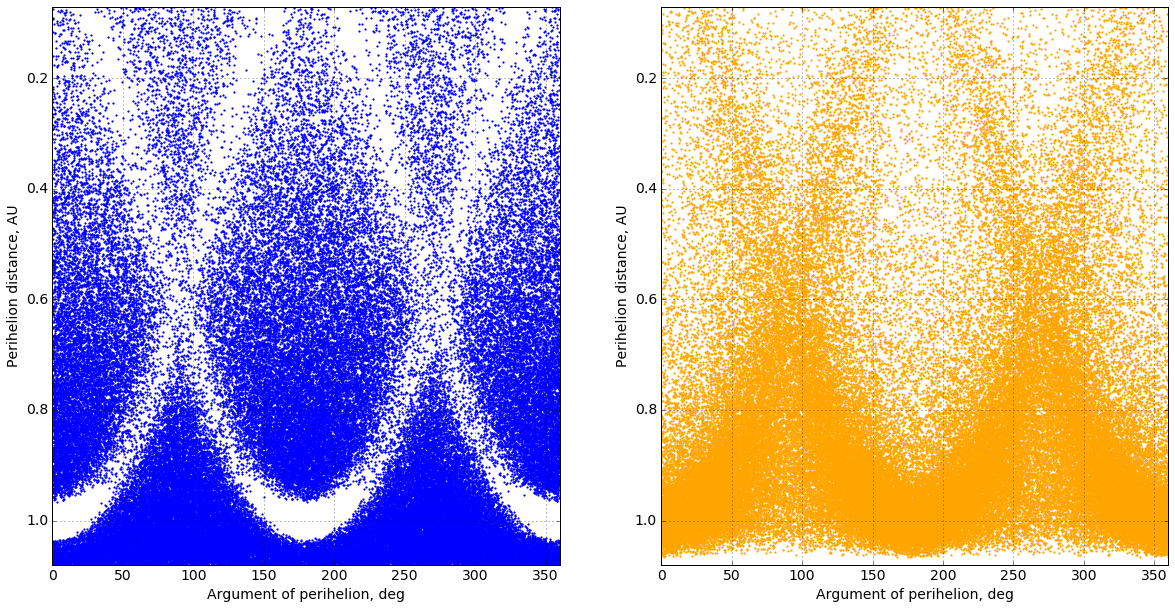

In [36]:
cols = ['w', 'q']
labels = [vd.colnames['w'], vd.colnames['q']]
vd.display_param2d(cols, labels, datasets_gen, invertaxes=[0,1])

** Plot distributions of 'w' and 'q' parameters for the set of generated uniform asteroids **

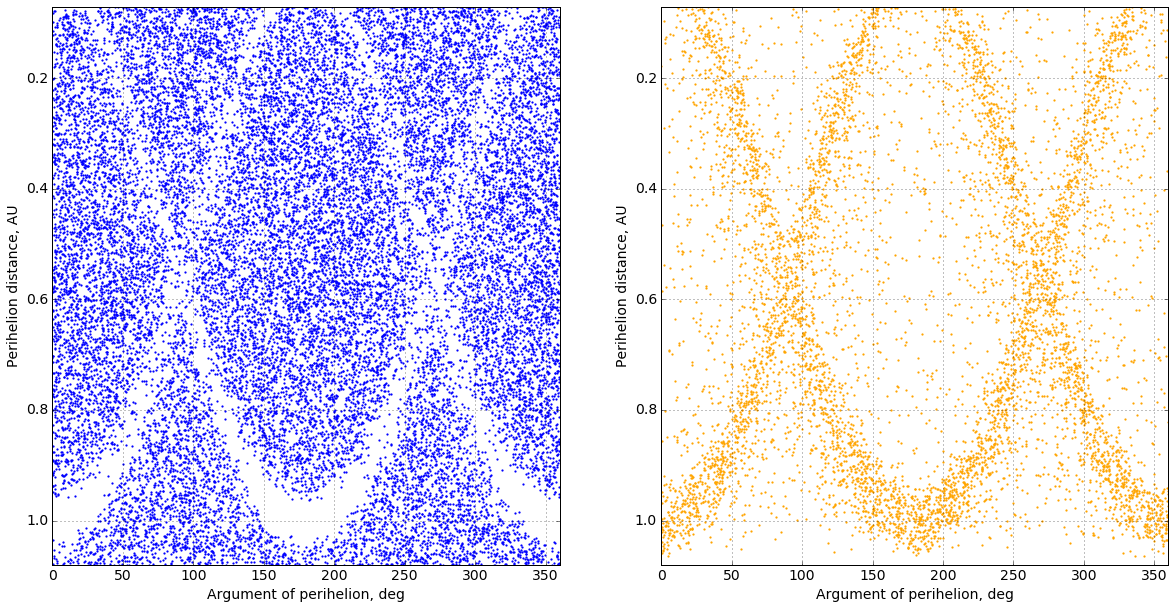

In [37]:
vd.display_param2d(cols, labels, datasets_genu, invertaxes=[0,1])

### Split all apollo asteroids by several clusters

** Amplify symmetry in 'w' by mirroring datasets **

In [38]:
haz_genu = ld.add_doublemirror_column(haz_genu, 'w', 180)
nohaz_genu = ld.add_doublemirror_column(nohaz_genu, 'w', 180)

In [120]:
haz_gen_mir = ld.add_doublemirror_column(haz_gen, 'w', 180)
nohaz_gen_mir = ld.add_doublemirror_column(nohaz_gen, 'w', 180)

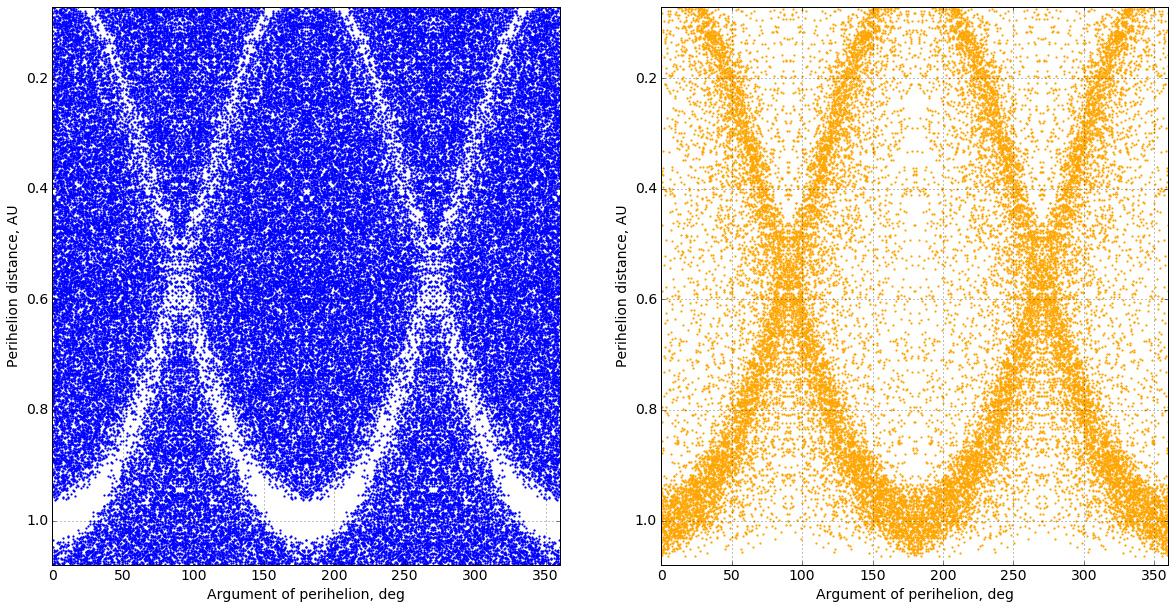

In [40]:
vd.display_param2d(cols, labels, [haz_genu, nohaz_genu], invertaxes=[0,1])

** Cut 2 parameters (w and q) from the datasets **

In [41]:
# haz_real_cut, nohaz_real_cut = ld.cut_2params(cols, datasets_real)
# haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cols, datasets_gen)
# haz_genu_cut, nohaz_genu_cut = ld.cut_2params(cols, datasets_genu)

haz_real_cut, nohaz_real_cut = ld.cut_params(haz_real, nohaz_real, cols)
haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cols)
haz_genu_cut, nohaz_genu_cut = ld.cut_params(haz_genu, nohaz_genu, cols)

**Normalize datasets**

In [42]:
# reload(al)
bounds = al.common_bounds([haz_real_cut, nohaz_real_cut, 
                           haz_gen_cut, nohaz_gen_cut,
                           haz_genu_cut, nohaz_genu_cut])

haz_gen_cut, haz_gen_sc = al.normalize_dataset(haz_gen_cut, bounds=bounds)
nohaz_gen_cut, nohaz_gen_sc = al.normalize_dataset(nohaz_gen_cut, bounds=bounds)

haz_genu_cut, haz_genu_sc = al.normalize_dataset(haz_genu_cut, bounds=bounds)
nohaz_genu_cut, nohaz_genu_sc = al.normalize_dataset(nohaz_genu_cut, bounds=bounds)

haz_real_cut, haz_real_sc = al.normalize_dataset(haz_real_cut, bounds=bounds)
nohaz_real_cut, nohaz_real_sc = al.normalize_dataset(nohaz_real_cut, bounds=bounds)

** Get common data x and y scales **

In [43]:
scale_sets = [haz_gen_sc, nohaz_gen_sc, 
              haz_genu_sc, nohaz_genu_sc, 
              haz_real_sc, nohaz_real_sc] 

scales = ld.common_scales(scale_sets)

In [121]:
haz_gen_mir_cut, nohaz_gen_mir_cut = ld.cut_params(haz_gen_mir, nohaz_gen_mir, cols)

haz_gen_mir_cut, haz_gen_mir_sc = al.normalize_dataset(haz_gen_mir_cut, bounds=bounds)
nohaz_gen_mir_cut, nohaz_gen_mir_sc = al.normalize_dataset(nohaz_gen_mir_cut, bounds=bounds)

**Split data by clusters based on uniform dataset**

In [76]:
# DBSCAN parameters
eps = [0.022]
min_samples = [105]
dens_layers = zip(eps, min_samples)
extracted_clusters = al.extract_dbclusters(nohaz_genu_cut, dens_layers)

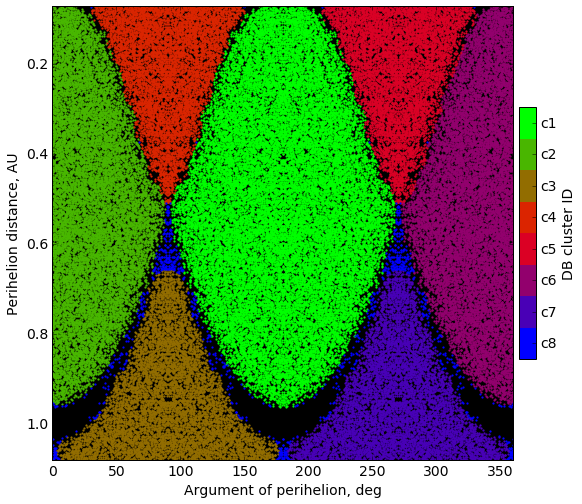

In [77]:
# reload(vd)
vd.plot_densclusters(extracted_clusters, labels=labels, cmap='brg', 
                     scales=scales, invertaxes=[0, 1], figsize=(8,7))

** Merge symmetric clusters**

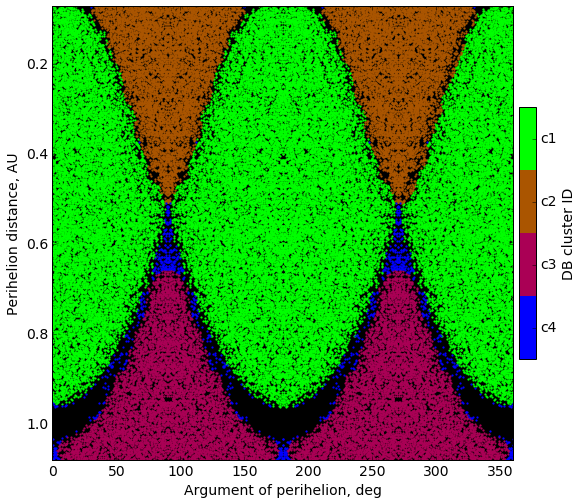

In [78]:
merged_clusters = al.merge_dbclusters(extracted_clusters, [[1,2,6], [4,5], [7,3]], merge_rest=False)
vd.plot_densclusters(merged_clusters, scales=scales, labels=labels, cmap='brg', invertaxes=[0, 1], figsize=(8,7))

### Transform clusters

In [100]:
c1, c2, c3, c4 = merged_clusters

** Split last cluster by the value of 'q'**

In [ ]:
# Split last cluster by mid value of normalized q
qsplit = 0.46
c4_q = c4[:,1]
c41 = c4[np.where(c4_q <= qsplit)]
c42 = c4[np.where(c4_q > qsplit)]

** Merge clusters **

In [101]:
c1_ = np.concatenate((c3, c42))
c2_ = deepcopy(c1)
c3_ = np.concatenate((c2, c41))

** Set IDs for transformed clusters **

In [102]:
c1_[:,2], c2_[:,2], c3_[:,2] = 1.0, 2.0, 3.0

** Build new set of clusters **

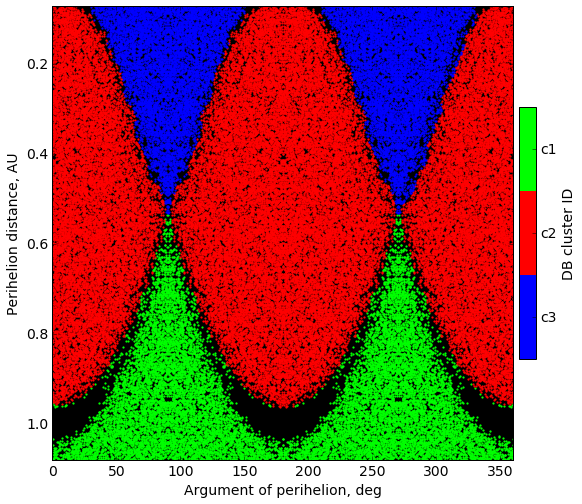

In [106]:
# reload(vd)
# split_clusters = [c11, c12, c2_, c31, c32]
split_clusters = [c1_, c2_, c3_]
# split_clusters = [c01, c11, c12]
vd.plot_densclusters(split_clusters, scales=scales, labels=labels, cmap='brg', invertaxes=[0, 1], figsize=(8,7))

**Extract hazardous belt from the generated uniform set of hazardous asteroids**

In [107]:
eps = [0.028]
min_samples = [80]
dens_layers = zip(eps, min_samples)
extracted_clusters_X = al.extract_dbclusters(haz_genu_cut, dens_layers)

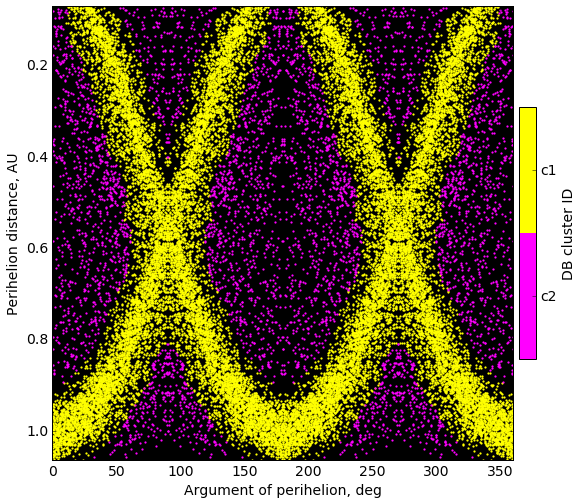

In [108]:
# reload(vd)
vd.plot_densclusters(extracted_clusters_X, scales=scales, labels=labels, cmap='spring', 
                     invertaxes=[0, 1], figsize=(8,7))

** Edit hazardous belt ID and add it to the cluster set**

In [109]:
c5, c6 = extracted_clusters_X
c5[:,2] = 4.0
split_clusters.append(c5)

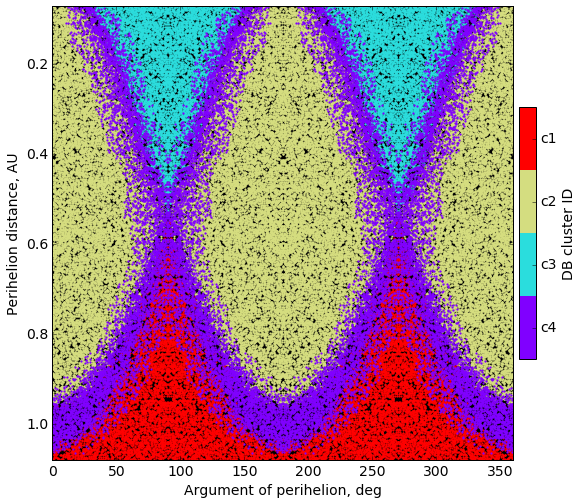

In [112]:
# reload(vd)
vd.plot_densclusters(split_clusters, scales=scales, labels=labels, cmap='rainbow', 
                     invertaxes=[0, 1], figsize=(8,7))

### Train SVM classifier using clusters' IDs as the class reference

In [118]:
reload(al)
clf = svm.SVC(gamma=6., C=1000)
xtrain, clf, haz_prob = al.classify_dbclusters(split_clusters, clf, haz_real_cut, nohaz_real_cut)

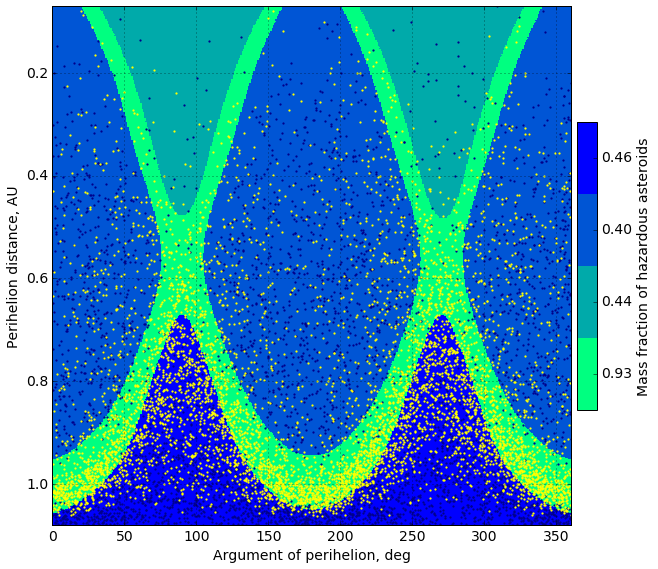

In [119]:
reload(vd)
# haz=haz_real_cut, nohaz=nohaz_real_cut,
# scales=scales
# rescale=False
vd.plot_classifier(xtrain, clf, num=400, haz=haz_real_cut, nohaz=nohaz_real_cut, figsize=(9,8),
                   clustprobs=haz_prob[1:], labels=labels, invertaxes=[0, 1], scales=scales,
                   cmap='winter')

**Classify generated sets of asteroids by cluster IDs**

In [122]:
haz_classify = clf.predict(haz_gen_cut)
nohaz_classify = clf.predict(nohaz_gen_cut)

In [123]:
hazm_classify = clf.predict(haz_gen_mir_cut)
nohazm_classify = clf.predict(nohaz_gen_mir_cut)

In [124]:
hazu_classify = clf.predict(haz_genu_cut)
nohazu_classify = clf.predict(nohaz_genu_cut)

** Export obtained asteroid subgroubs **

In [125]:
def export_subgroups(sg_ids, nmb, cls, dbs):
    
    haz_nmb = dirpath + nmb[0]
    nohaz_nmb = dirpath + nmb[1]
    haz_db, nohaz_db = dbs
    haz_cls, nohaz_cls = cls

    for i in sg_ids:
        haz_inds = np.where(haz_cls == i)[0]
        nohaz_inds = np.where(nohaz_cls == i)[0]
        haz_rest_inds = np.where(haz_cls != i)[0]
        nohaz_rest_inds = np.where(nohaz_cls != i)[0]
        
        haz_gen_sg = haz_db.iloc[haz_inds]
        nohaz_gen_sg = nohaz_db.iloc[nohaz_inds]
        haz_gen_rest = haz_db.iloc[haz_rest_inds]
        nohaz_gen_rest = nohaz_db.iloc[nohaz_rest_inds]
        
        haz_name = haz_nmb %i
        nohaz_name = nohaz_nmb %i
        haz_name_rest = haz_name[:-2] + '_rest.p'
        nohaz_name_rest = nohaz_name[:-2] + '_rest.p'
        
        rdb.dumpObject(haz_gen_sg, haz_name)
        rdb.dumpObject(nohaz_gen_sg, nohaz_name)
        rdb.dumpObject(haz_gen_rest, haz_name_rest)
        rdb.dumpObject(nohaz_gen_rest, nohaz_name_rest)


In [126]:
dirpath = './asteroid_data/'

haz_nmb = 'haz_gen_sg%d.p'
nohaz_nmb = 'nohaz_gen_sg%d.p'

hazm_nmb = 'haz_genm_sg%d.p'
nohazm_nmb = 'nohaz_genm_sg%d.p'

hazu_nmb = 'haz_genu_sg%d.p'
nohazu_nmb = 'nohaz_genu_sg%d.p'
      
sg_ids = range(1, len(split_clusters) + 1)

In [127]:
export_subgroups(sg_ids, [haz_nmb, nohaz_nmb], [haz_classify, nohaz_classify], [haz_gen, nohaz_gen])

In [128]:
export_subgroups(sg_ids, [hazm_nmb, nohazm_nmb], [hazm_classify, nohazm_classify], [haz_gen_mir, nohaz_gen_mir])

In [129]:
export_subgroups(sg_ids, [hazu_nmb, nohazu_nmb], [hazu_classify, nohazu_classify], [haz_genu, nohaz_genu])